In [1]:
%matplotlib inline


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor



df = pd.read_csv("dataset/train.csv")

# Show data structure
print("Initial Columns:", df.columns)


# Split week column into day, month, year (string -> integer)
df[['day', 'month', 'year']] = df['week'].str.split('/', expand=True)
df[['day', 'month', 'year']] = df[['day', 'month', 'year']].astype(int)

# Drop original week column
df = df.drop('week', axis=1)


if 'record_ID' in df.columns:
    df = df.drop('record_ID', axis=1)



df = df[df.units_sold < df.units_sold.quantile(0.99)]


print("Final Columns Used for Training:", df.columns)



X = df.drop('units_sold', axis=1)
y = df['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())


Initial Columns: Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold'],
      dtype='object')
Final Columns Used for Training: Index(['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'units_sold', 'day', 'month', 'year'],
      dtype='object')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 118908, number of used features: 9
[LightGBM] [Info] Start training from score 47.924656

==== BASE LIGHTGBM MODEL PERFORMANCE ====
R² Score: 0.8416152364190661
RMSE: 16.988119284769525
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 118908, number of used features: 9
[LightGBM] [Info] Start training from score 47.924656

==== OPTIMIZED LIGHTGBM MODEL PERFORMANCE ====
R² Score: 0.8791724309228842
RMSE: 14.83787200

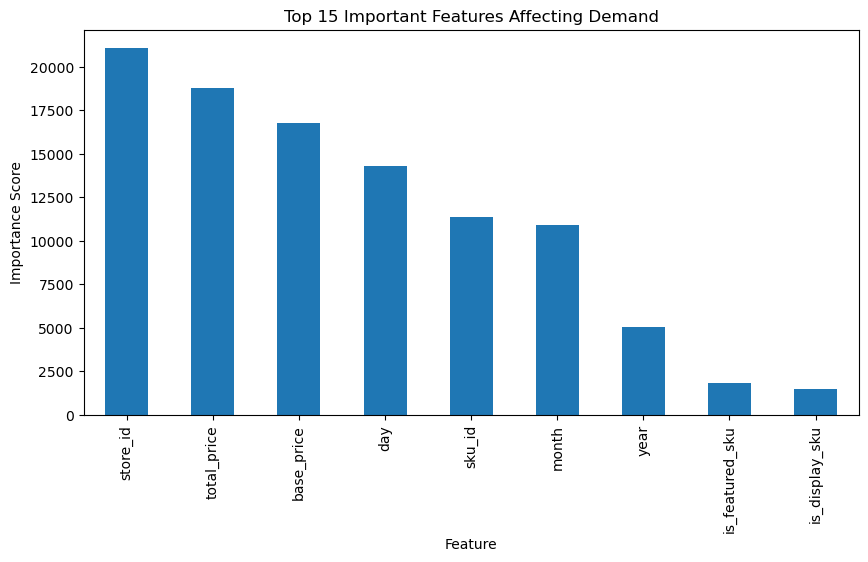

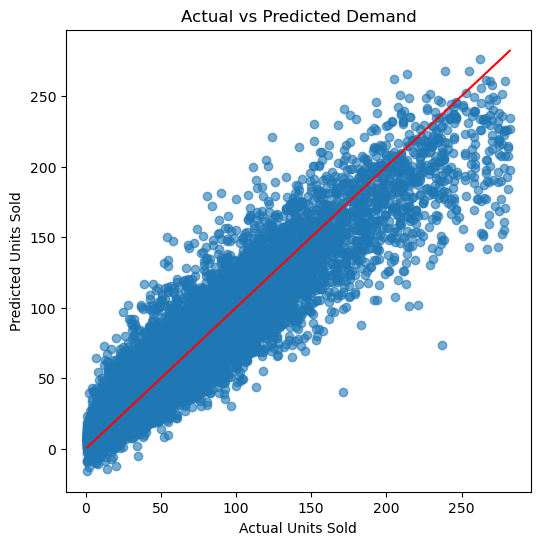

In [ ]:


lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

lgbm_model.fit(X_train_filled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_filled)

print("\n==== BASE LIGHTGBM MODEL PERFORMANCE ====")
print("R² Score:", r2_score(y_test, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))



param_grid = {
    "num_leaves": [31, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

tuner = RandomizedSearchCV(
    LGBMRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

tuner.fit(X_train_filled, y_train)

best_model = tuner.best_estimator_
y_pred_best = best_model.predict(X_test_filled)

print("\n==== OPTIMIZED LIGHTGBM MODEL PERFORMANCE ====")
print("R² Score:", r2_score(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Best Hyperparameters:", tuner.best_params_)


importance = pd.Series(best_model.feature_importances_, index=X.columns).nlargest(15)

plt.figure(figsize=(10,5))
importance.plot(kind='bar')
plt.title("Top 15 Important Features Affecting Demand")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted Demand")
plt.show()

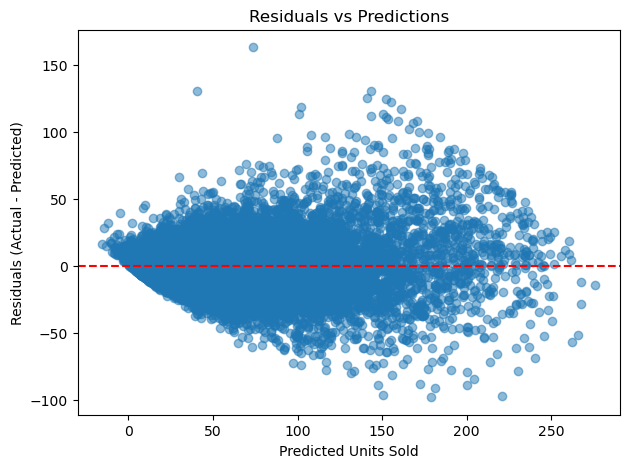

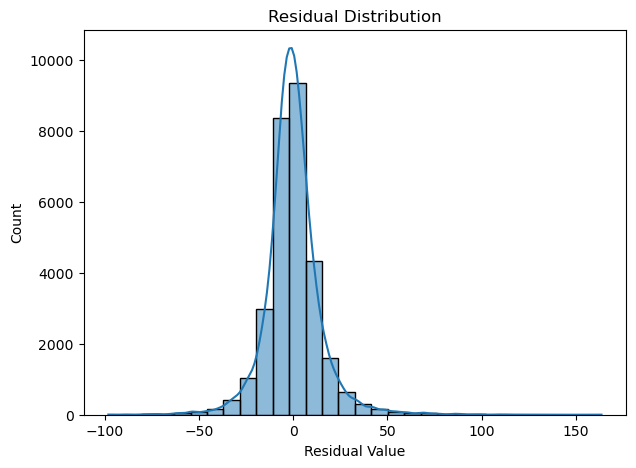

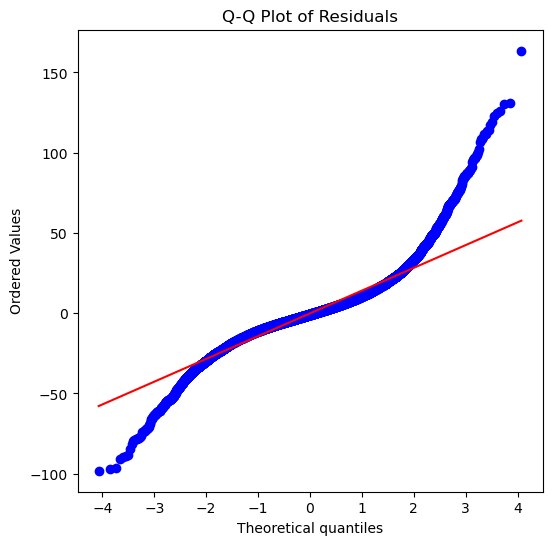

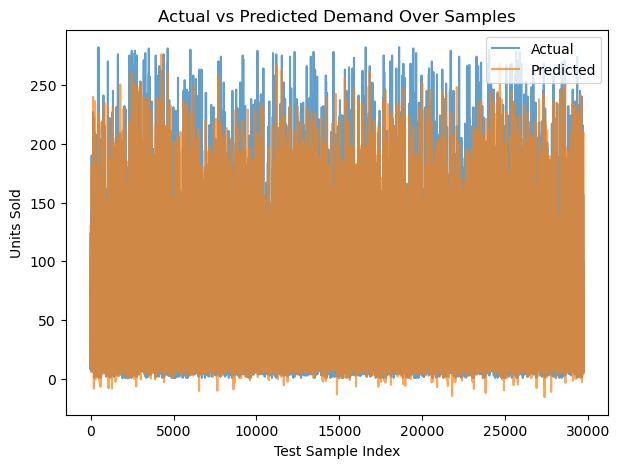

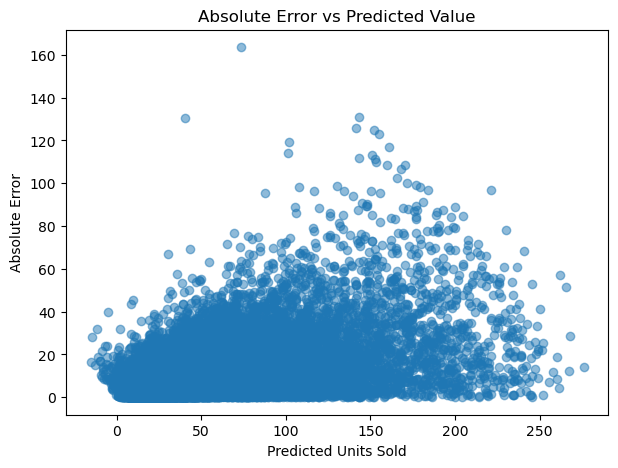

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats


residuals = y_test - y_pred_best


plt.figure(figsize=(7,5))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Units Sold")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predictions")
plt.show()


plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residual Value")
plt.title("Residual Distribution")
plt.show()


plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


plt.figure(figsize=(7,5))
plt.plot(range(len(y_test)), y_test.values, label='Actual', alpha=0.7)
plt.plot(range(len(y_test)), y_pred_best, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Demand Over Samples")
plt.xlabel("Test Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


abs_error = np.abs(residuals)
plt.figure(figsize=(7,5))
plt.scatter(y_pred_best, abs_error, alpha=0.5)
plt.xlabel("Predicted Units Sold")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs Predicted Value")
plt.show()
